**Clasificación usando Clasificador de Bayes Ingenuo, Regresión Logística Multinomial y Support Vector Machine del dataset propio**

<p align="justify">En este apartado vamos a realizar la primera clasificación de nuestro dataset usando los clasificadores que mejores resultados han obtenido en el apartado anterior del trabajo.

<p align="justify">Nuestro dataset está compuesto por 9343 mensajes recibidos por una empresa dedicada a la enseñanza no reglada especializada en cursos de formación de oposiciones de Enfermería. Los mensajes están divididos en siete clases distintas:

<p align="justify">- Solicitud de información: El alumno o potencial alumno solicita información de algún aspecto del curso o del material.

<p align="justify">- Motivación: El alumno indica su estado de ánimo respecto al curso, si está motivado o le falta motivación y necesita ayuda en este aspecto.

<p align="justify">- Pedidos: El alumno solicita información sobre un pedido que ha realizado, o está en proceso de realizar.

<p align="justify">- Envíos: El alumno solicita información acerca del estado de un envío, pregunta por qué no ha llegado todavía...

<p align="justify">- Problema técnico: El alumno está experimentando un problema con la plataforma, no puede acceder, tiene contenido bloqueado, no le cargan los vídeos...

<p align="justify">- Duda teórica: El alumno tiene una duda relacionada con el temario del curso y solicita ayuda para resolverla.

<p align="justify">- Neurolingüística: El alumno indica el resultado obtenido en el test neurolingüístico para saber el tipo de estudiante que son: visual, aditivo o kinestésico.

#Análisis del dataset#

<p align="justify">Lo primero que vamos a hacer para poder analizar el dataset es comprobar el balanceo de las distintas clases.

In [ ]:
!pip install pyyaml

In [ ]:
import yaml

# Creamos una función que cree un dataset a partir de un fichero yaml
def yaml_to_dataset(file_path):
    with open(file_path, 'r', encoding="utf8") as file:
        data = yaml.safe_load(file)

    messages = [d['message'] for d in data]
    labels = [d['label'] for d in data]

    return {'data': messages, 'labels': labels}

In [ ]:
!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Creamos una función para mostrar las ocurrencias de cada clase
def show_labels_ocurrences(dataset):
    label_ocurrences = Counter(dataset['labels'])
    labels, ocurrences = zip(*label_ocurrences.items())
    total = sum(ocurrences)

    plt.bar(labels, ocurrences)
    plt.xlabel('Clase')
    plt.ylabel('Nº de ocurrencias')
    plt.title('Distribución de las clases')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Añadimos el número de ocurrencias de cada clase
    for i, count in enumerate(ocurrences):
        plt.text(i, count+0.05*total, str(count), ha='center', va='bottom')
    plt.text(len(labels)//2, 1.1*total, f'Total: {total}', ha='center', va='bottom')
    plt.ylim(0, 1.2*max(ocurrences))

In [ ]:
# Cargamos el dataset
dataset = yaml_to_dataset('/Users/34653/Desktop/new_dataset.yml')


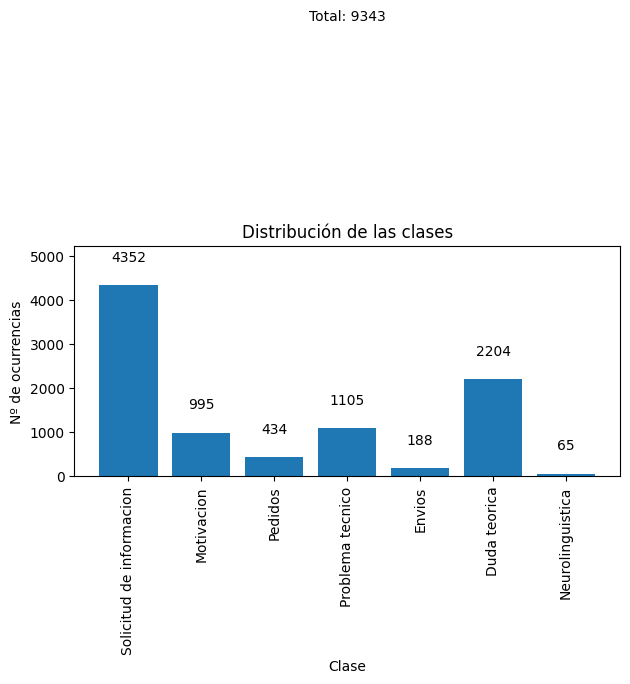

In [ ]:
show_labels_ocurrences(dataset)

<p align="justify">Como podemos observar hay un gran desbalanceo en nuestro dataset, habiendo una clase que supone más del 46% del dataset (Solicitud de Información) y otra que supone un porcentaje menor del 0,7% (Neurolingüística).

<p align="justify">Este hecho es muy relevante y debemos de tenerlo en cuenta a la hora de trabajar con los datos para realizar la clasificación.

#Clasificación del dataset#

<p align="justify">Para poder clasificar el dataset debemos realizar el proprocesado que hemos visto en el apartado anterior. Para ello vamos a crear una función para relizar el proceso de generalización explicada anteriormente, cambiamos las letras acentuadas por las mismas letras sin acentuar, eliminamos las palabras genéricas que no aportan información, eliminamos los signos de puntuación y tokenizamos.

<p align="justify">Para realizar la codificación vamos a usar TF-IDF, tal como hemos explicado en el capítulo anterior.

<p align="justify">En este caso, al tratarse de mensajes que los alumnos han mandando por diversas plataformas como WhatsApp y Telegram en un contexto informal, los mensajes contienen abreviaturas, por ello vamos a crear una función auxiliar para reemplazar las abreviaturas más comunes por su palabra correspondiente.

In [ ]:
!pip install spacy
!python -m spacy download es_core_news_lg

     ---------------------------------------- 0.0/568.0 MB ? eta -:--:--
     ---------------------------------------- 0.2/568.0 MB 5.8 MB/s eta 0:01:39
     --------------------------------------- 1.5/568.0 MB 15.6 MB/s eta 0:00:37
     --------------------------------------- 5.8/568.0 MB 41.2 MB/s eta 0:00:14
      ------------------------------------- 11.5/568.0 MB 93.0 MB/s eta 0:00:06
      ------------------------------------- 13.9/568.0 MB 81.8 MB/s eta 0:00:07
     - ------------------------------------ 17.2/568.0 MB 81.8 MB/s eta 0:00:07
     - ------------------------------------ 20.4/568.0 MB 65.6 MB/s eta 0:00:09
     - ------------------------------------ 21.5/568.0 MB 65.6 MB/s eta 0:00:09
     - ------------------------------------ 25.8/568.0 MB 65.2 MB/s eta 0:00:09
     - ------------------------------------ 27.9/568.0 MB 59.5 MB/s eta 0:00:10
     -- ----------------------------------- 30.2/568.0 MB 65.2 MB/s eta 0:00:09
     -- ----------------------------------- 34.

In [ ]:
import re
import string
import unicodedata
import spacy
from spacy.lang.es.stop_words import STOP_WORDS

# Creamos la función auxiliar para reemplazar las abreviaturas
def replace_abbreviations(text, abbreviations):

    for key, value in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(key), value, text)
    return text


abbreviations = {
    'x' : 'por',
    'xq': 'porque',
    'pq': 'porque',
    'k': 'que',
    'tb': 'también',
    'tmb': 'también',
    'd': 'de',
    'cn': 'con',
    'm': 'me',
    'q': 'que',
    'qe': 'que',
    't': 'te',
}

nlp = spacy.load('es_core_news_lg')

# Creamos la función para preprocesar y tokenizar el dataset
def preprocess_tokenize_spanish(text):

  # Pasamos todo el texto a minúsculas
  text = text.lower()

  # Reemplazamos las abreviaturas
  text = replace_abbreviations(text, abbreviations)

  # Borramos las URL que puedan contener los mensajes
  text = re.sub(r'http\S+', '', text)

  # Cargamos una lista de signos de puntuación para eliminarlos al preprocesar
  punctuations = string.punctuation + '...' + '--' + '``' + '\'' + ''
  text = text.translate(str.maketrans('', '', punctuations))

  # Reemplazamos las letras acentuadas por sus equivalentes no acentuadas
  text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

  # Tokenizamos y generalizamos
  doc = nlp(text)
  tokens = [token.lemma_ for token in doc if token not in STOP_WORDS]

  return tokens


In [ ]:
# Creamos una función para imprimir por pantalla el informe de clasificación medio de todos los informes al usar Kfold CrossValidation
def print_mean_classification_report(classification_reports):
  n_folds = len(classification_reports)
  total_report = {}

  # Sumamos para cada métrica
  for report in classification_reports:
      for metric, scores in report.items():

        if metric not in total_report:
          if metric != 'accuracy':
            total_report[metric] = scores

        else:
          if metric not in ['accuracy']:
            total_report[metric] = {k: total_report[metric][k] + scores[k] for k in scores}

  # Dividimos entre el número de folds de validación
  mean_report = {metric: {k: v/n_folds for k, v in scores.items()} for metric, scores in total_report.items()}

  # Damos formato
  fmt_string = '{:<25} {:<25} {:<25} {:<25} {:<25}'

  # Mostramos por pantalla las métricas
  print(fmt_string.format('', 'precision', 'recall', 'f1-score', 'support'))

  # Mostramos el informe de clasificiación
  for metric, scores in mean_report.items():
      precision = scores['precision']
      recall = scores['recall']
      f1_score = scores['f1-score']
      support = scores['support']
      print(fmt_string.format(metric, precision, recall, f1_score, support))

In [ ]:
!pip install seaborn

In [ ]:
import pandas as pd

# Creamos una función para mostrar la matriz de confusión total porcentual de todas las matrices de confusión al usar Kfold CrossValidation
def print_percentage_confusion_matrix(confusion_matrices, index):

  # Inicalizamos la matriz de suma
  sum_matrix = np.zeros_like(confusion_matrices[0])

  # Sumamos todas las matrices
  for matrix in confusion_matrices:
    sum_matrix += matrix

  sum_matrix = sum_matrix.astype('float') / sum_matrix.sum(axis=1)[:, np.newaxis]

  # Pasamos la matriz a dataframe
  cm_df = pd.DataFrame(sum_matrix, index = index, columns = index)

  #Mostramos la matriz de confusión
  plt.figure(figsize=(6,6))
  sns.heatmap(cm_df, annot=True, fmt=".2f")
  plt.title('Matriz de confusión')
  plt.ylabel('Valores reales')
  plt.xlabel('Predicciones')
  plt.show()


**SVM**

                          precision                 recall                    f1-score                  support                  
Duda teorica              0.8320837173417182        0.8852200740436036        0.8577316593218564        220.4                    
Envios                    0.5899490392648288        0.5643274853801169        0.5725390931273283        18.8                     
Motivacion                0.9053467693137536        0.8533333333333333        0.8773270359662646        99.5                     
Neurolinguistica          0.9708333333333332        0.7380952380952381        0.8206759906759906        6.5                      
Pedidos                   0.6805671028683329        0.6800211416490486        0.6779433675431428        43.4                     
Problema tecnico          0.6495098857074558        0.742031122031122         0.6924759525778145        110.5                    
Solicitud de informacion  0.8982064475390544        0.8515638511019722        0.8741478749

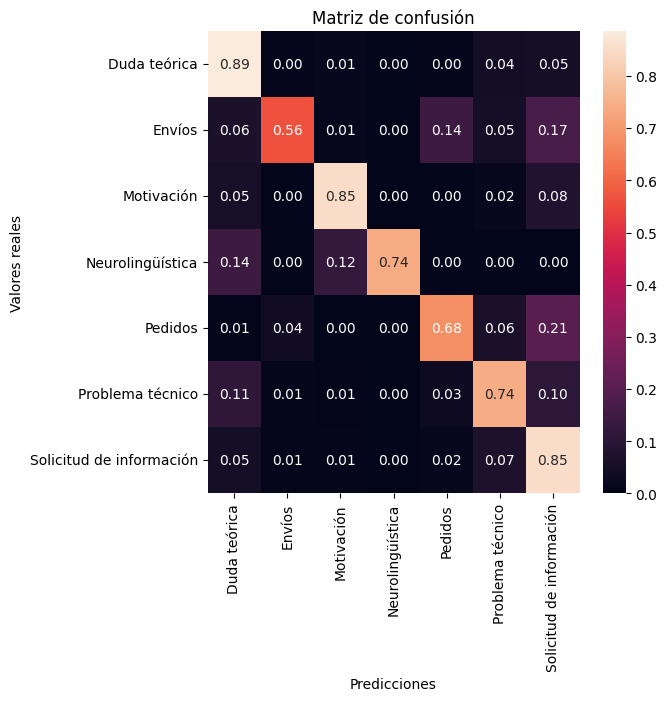

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings

# Ignoramos los warnings de la categoría UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# Importamos el clasificador
from sklearn.svm import SVC

# Importamos Validación Cruzada Estratificada
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

# Cargamos el dataset
dataset = yaml_to_dataset('/Users/34653/Desktop/new_dataset.yml')
data = np.array(dataset['data'])
labels = np.array(dataset['labels'])

# Creamos una lista para guardar los distintos classification reports y las accuracies
classification_reports = []
accuracies = []

# Creamos una lista para guardar las distintas confusion matrix
confusion_matrices = []

# Lista de índices
index = ['Duda teórica','Envíos', 'Motivación', 'Neurolingüística', 'Pedidos', 'Problema técnico', 'Solicitud de información']

# Obtenemos los conjuntos de entrenamiento y test para cada ejecución
for i, (train_index, test_index) in enumerate(skfold.split(data, labels)):
  data_train, data_test = data[train_index], data[test_index]
  labels_train, labels_test = labels[train_index], labels[test_index]

  # Realizamos el preprocesamiento de cada conjunto
  vectorizer = TfidfVectorizer(tokenizer=preprocess_tokenize_spanish)
  vectors_train = vectorizer.fit_transform(data_train)
  vectors_test = vectorizer.transform(data_test)

  # Creamos el clasificador
  svm = SVC(kernel='rbf', class_weight='balanced')

  # Realizamos el entrenamiento
  svm.fit(vectors_train, labels_train)

  # Realizamos la predicción con los datos de test
  accuracy = svm.score(vectors_test, labels_test)
  accuracies.append(accuracy)
  pred = svm.predict(vectors_test)
  report = classification_report(labels_test, pred, output_dict=True, zero_division=0)
  classification_reports.append(report)
  cm = confusion_matrix(labels_test, pred)
  confusion_matrices.append(cm)

print_mean_classification_report(classification_reports)
print("Accuracy: " , np.mean(np.array(accuracies)))
print("\n")
print_percentage_confusion_matrix(confusion_matrices, index)


**Multinomial Logistic Regression**

                          precision                 recall                    f1-score                  support                  
Duda teorica              0.8458738837637109        0.8530213903743317        0.8488690222752819        220.4                    
Envios                    0.33705649139387595       0.7982456140350876        0.43541559771821464       18.8                     
Motivacion                0.8555003442904692        0.8634141414141414        0.8531305388051672        99.5                     
Neurolinguistica          0.6816017316017315        0.869047619047619         0.7040764790764791        6.5                      
Pedidos                   0.645646532339828         0.5304439746300212        0.5173301327778528        43.4                     
Problema tecnico          0.6353542147712679        0.7493120393120394        0.6856482558406183        110.5                    
Solicitud de informacion  0.927367750493952         0.7815000527259306        0.8468441692

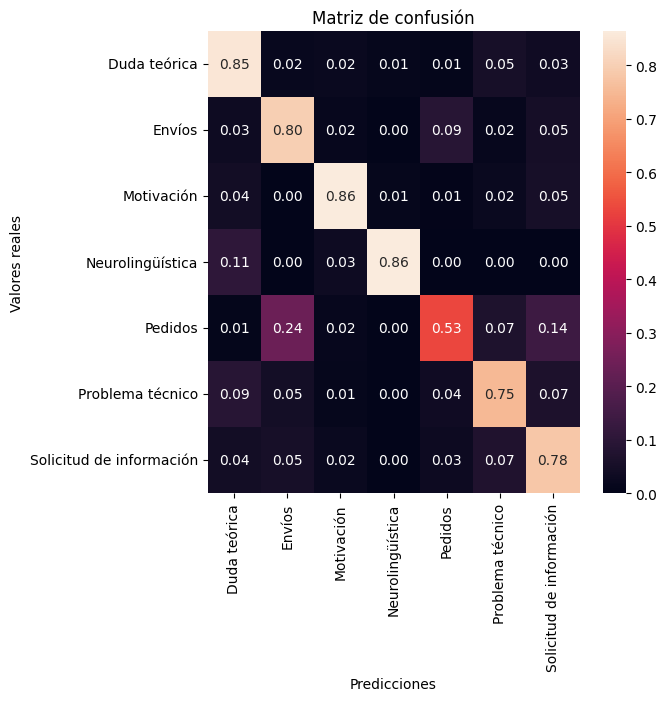

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings

# Ignoramos los warnings de la categoría UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# Importamos el clasificador
from sklearn.linear_model import LogisticRegression

# Importamos Validación Cruzada Estratificada
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

# Cargamos el dataset
dataset = yaml_to_dataset('/Users/34653/Desktop/new_dataset.yml')
data = np.array(dataset['data'])
labels = np.array(dataset['labels'])

# Creamos una lista para guardar los distintos classification reports y las accuracies
classification_reports = []
accuracies = []

# Creamos una lista para guardar las distintas confusion matrix
confusion_matrices = []

# Lista de índices
index = ['Duda teórica','Envíos', 'Motivación', 'Neurolingüística', 'Pedidos', 'Problema técnico', 'Solicitud de información']

# Obtenemos los conjuntos de entrenamiento y test para cada ejecución
for i, (train_index, test_index) in enumerate(skfold.split(data, labels)):
  data_train, data_test = data[train_index], data[test_index]
  labels_train, labels_test = labels[train_index], labels[test_index]

  # Realizamos el preprocesamiento de cada conjunto
  vectorizer = TfidfVectorizer(tokenizer=preprocess_tokenize_spanish)
  vectors_train = vectorizer.fit_transform(data_train)
  vectors_test = vectorizer.transform(data_test)

  # Creamos el clasificador
  lr_multinomial = LogisticRegression(multi_class='multinomial', solver='saga', class_weight='balanced')

  # Realizamos el entrenamiento
  lr_multinomial.fit(vectors_train, labels_train)

  # Realizamos la predicción con los datos de test
  accuracy = lr_multinomial.score(vectors_test, labels_test)
  accuracies.append(accuracy)
  pred = lr_multinomial.predict(vectors_test)
  report = classification_report(labels_test, pred, output_dict=True, zero_division=0)
  classification_reports.append(report)
  cm = confusion_matrix(labels_test, pred)
  confusion_matrices.append(cm)

print_mean_classification_report(classification_reports)
print("Accuracy: " , np.mean(np.array(accuracies)))
print("\n")
print_percentage_confusion_matrix(confusion_matrices, index)


**Clasificador de Bayes Ingenuo**

                          precision                 recall                    f1-score                  support                  
Duda teorica              0.9155069044821209        0.7060016454134102        0.7969353292504859        220.4                    
Envios                    0.0                       0.0                       0.0                       18.8                     
Motivacion                0.9955050505050504        0.36273737373737375       0.5283939275241603        99.5                     
Neurolinguistica          0.1                       0.016666666666666666      0.02857142857142857       6.5                      
Pedidos                   0.0                       0.0                       0.0                       43.4                     
Problema tecnico          0.9928571428571429        0.07597870597870598       0.14006308132560713       110.5                    
Solicitud de informacion  0.6017562857532649        0.9944832858799959        0.7497643069

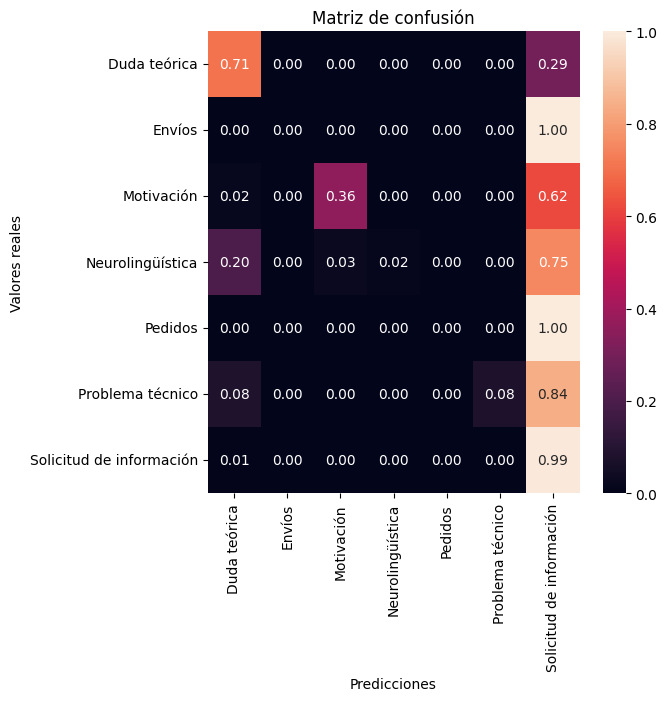

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings

# Ignoramos los warnings de la categoría UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# Importamos el clasificador
from sklearn.naive_bayes import MultinomialNB

# Importamos Validación Cruzada Estratificada
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

# Cargamos el dataset
dataset = yaml_to_dataset('/Users/34653/Desktop/new_dataset.yml')
data = np.array(dataset['data'])
labels = np.array(dataset['labels'])

# Creamos una lista para guardar los distintos classification reports y las accuracies
classification_reports = []
accuracies = []


# Creamos una lista para guardar las distintas confusion matrix
confusion_matrices = []

# Lista de índices
index = ['Duda teórica','Envíos', 'Motivación', 'Neurolingüística', 'Pedidos', 'Problema técnico', 'Solicitud de información']

# Obtenemos los conjuntos de entrenamiento y test para cada ejecución
for i, (train_index, test_index) in enumerate(skfold.split(data, labels)):
  data_train, data_test = data[train_index], data[test_index]
  labels_train, labels_test = labels[train_index], labels[test_index]

  # Realizamos el preprocesamiento de cada conjunto
  vectorizer = TfidfVectorizer(tokenizer=preprocess_tokenize_spanish)
  vectors_train = vectorizer.fit_transform(data_train)
  vectors_test = vectorizer.transform(data_test)

  # Creamos el clasificador
  clf = MultinomialNB()

  # Realizamos el entrenamiento
  clf.fit(vectors_train, labels_train)

  # Realizamos la predicción con los datos de test
  accuracy = clf.score(vectors_test, labels_test)
  accuracies.append(accuracy)
  pred = clf.predict(vectors_test)
  report = classification_report(labels_test, pred, output_dict=True, zero_division=0)
  classification_reports.append(report)
  cm = confusion_matrix(labels_test, pred)
  confusion_matrices.append(cm)

print_mean_classification_report(classification_reports)
print("Accuracy: " , np.mean(np.array(accuracies)))
print("\n")
print_percentage_confusion_matrix(confusion_matrices, index)



<p align="justify">Una vez realizadas las clasificaciones usando los métodos de SVM, Regresión Logística y Clasificador de Bayes Ingenuo, procedemos a analizar los resultados para estos clasificadores.

<p align="justify">Debemos tener en cuenta que las clases no están balanceadas, por lo que a la hora de evaluar como de bien clasifican los modelos independientemente de la frecuencia de la clase tenemos que valorar la métrica "macro-avg". Teniendo esto en cuenta, podemos comprobar que SVM es el modelo que logra un mejor resultado con un 0,77 aproximadamente en la métrica F1. L regresión logística se queda en un 0,70 y el clasificador de bayes ingenuo no pasa del 0,32.

<p align="justify">Como también se puede comprobar en las matriz de confusión del clasificador SVM, los envíos son la clase que más se confunde con otras, esto se puede deber a que los mensajes para pedir información sobre un pedido son bastante parecidos a una solicitud de información genérica acerca de un producto y de ahí la confusión a la hora de clasificar.

<p align="justify">Esto se puede observar también en el modelo que usa regresión logística, si bien es cierto que este tiene un general peor desempeño que el modelo de Support Vector Machine.

<p align="justify">En lo referente al Clasificador de Bayes Ingenuo, se tienden a clasificar todos los mensajes en la clase "Solicitud de Información", esto es debido a que esta clase es la que más datos contiene y por tanto se le asigna una mayor probabilidad que a las clases que están infrarrepresentadas.


<p align="justify">En este capítulo hemos realizado una primera aproximación de cómo clasificar nuestro dataset usando clasificadores tradicionales de Machine Learning, en el siguiente apartado veremos cómo aplicar redes neuronales y deep learning en la clasificación con nuestros datos.
